Собрать класс датасет с функциями из ноутбука по генерации датасета. Надо функции перенести в класс + добавить возможность при инициализации менять длину последовательности кадров. Построить график зависимости от количества кадров в последовательности (уменьшать и увеличивать) Построить график зависимости от количества модулей лстм.

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import zipfile
import numpy as np
import pandas as pd

In [2]:
class Data(Dataset):
    def __init__(self, data_path, broken_files_path, chonk_len, transform=None):
        
        ##### список файлов с лейблами на каждый файл 
        self.chonk_len = chonk_len
        self.data_path = data_path
        working_files_with_labels, action_classes = self.read_data(data_path, broken_files_path)
        
        self.data = self.generate_data(working_files_with_labels)
        self.labels = self.data.iloc[:,-1]
        self.transform = transform


    def __len__(self):
        return len(self.data) 
    
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(45,75)
        label = self.labels[idx]
        if self.transform != None:
            item = transform(item)
        return (item, label) 
    
    def read_data(self, data_path, broken_files_path):
        labels = []
        files = []
        action_classes = {}
        counter = 0
        files_counter = {}
        training_subjects = list(range(0, 28)) #количество людей выполняющих действия
        training_classes = [8, 10, 22, 23, 27, 21] #классы которые будем использовать для обучения, полный список прдставлен тут https://github.com/shahroudy/NTURGB-D
        training_cameras = [1, 2, 3] 

        with open(broken_files_path, 'r') as f:
            broken_files = f.read().split("\n")

        raw_files = os.listdir(data_path)
        num_frames = 0

        for filename in raw_files:
            if filename not in broken_files:
                action_class = int(filename[filename.find('A') + 1:filename.find('A') + 4])
                subject_id = int(filename[filename.find('P') + 1:filename.find('P') + 4])
                camera_id = int(filename[filename.find('C') + 1:filename.find('C') + 4])
                if action_class in training_classes and camera_id in training_cameras:  #and subject_id in training_subjects:
                    if action_class in action_classes:
                        if files_counter[action_class] < 120:
                            files.append([filename,action_classes[action_class]])
                            files_counter[action_class] = files_counter[action_class] + 1
                    else:
                        action_classes.update({action_class : counter})
                        files_counter.update({action_class : 1})
                        counter+=1
                        files.append([filename,action_classes[action_class]])
    #                     labels.append([action_class])
        print("action classes: ", action_classes)
        print("action files: ", files_counter)

        return files, action_classes

    def read_skeleton_filter(self, file):
        with open(file, 'r') as f:
            skeleton_sequence = {}
            skeleton_sequence['numFrame'] = int(f.readline())
            skeleton_sequence['frameInfo'] = []
            for t in range(skeleton_sequence['numFrame']):
                frame_info = {}
                frame_info['numBody'] = int(f.readline())
                frame_info['bodyInfo'] = []

                for m in range(frame_info['numBody']):
                    body_info = {}
                    body_info_key = [
                        'bodyID', 'clipedEdges', 'handLeftConfidence',
                        'handLeftState', 'handRightConfidence', 'handRightState',
                        'isResticted', 'leanX', 'leanY', 'trackingState'
                    ]
                    body_info = {
                        k: float(v)
                        for k, v in zip(body_info_key, f.readline().split())
                    }
                    body_info['numJoint'] = int(f.readline())
                    body_info['jointInfo'] = []
                    for v in range(body_info['numJoint']):
                        joint_info_key = [
                            'x', 'y', 'z', 'depthX', 'depthY', 'colorX', 'colorY',
                            'orientationW', 'orientationX', 'orientationY',
                            'orientationZ', 'trackingState'
                        ]
                        joint_info = {
                            k: float(v)
                            for k, v in zip(joint_info_key, f.readline().split())
                        }
                        body_info['jointInfo'].append(joint_info)
                    frame_info['bodyInfo'].append(body_info)
                skeleton_sequence['frameInfo'].append(frame_info)

        return skeleton_sequence

    def read_xyz(self, file, max_body=1, num_joint=25):
        seq_info = self.read_skeleton_filter(file)
        data = np.zeros((max_body, seq_info['numFrame'], num_joint, 3))
        for n, f in enumerate(seq_info['frameInfo']):
            for m, b in enumerate(f['bodyInfo']):
                for j, v in enumerate(b['jointInfo']):
                    if m < max_body and j < num_joint:
                        data[m, n, j, :] = [v['x'], v['y'], v['z']]

                    else:
                        pass

        return data
        
    def create_coords_blocks(self, test_file, chonk_len):   
        frame_counter = 0
        new_labels = []
        new_frames = []
        blocks = []

        test_frames = self.read_xyz(self.data_path + test_file[0])[0]
        label = test_file[1]
        slice_len = chonk_len * int(len(test_frames)/chonk_len)


        for index in range(len(test_frames[:slice_len])):
            frame_counter += 1
            new_frames.append(test_frames[index].flatten())
            if frame_counter == chonk_len:
                frame_counter = 0
                blocks.append(np.array(new_frames))
                new_labels = new_labels + [label]
                new_frames = []


        return blocks, new_labels
    
    def generate_data(self, working_files_with_labels):
        data = []
        labels = []
        numbers = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0} 
        for file in working_files_with_labels:
            frames_blocks, label = self.create_coords_blocks(file, self.chonk_len)
            if label != [] and numbers[label[0]] <= 150:
                numbers[label[0]] = numbers[label[0]] + len(label)
                data = data + frames_blocks
                labels = labels + label
        data_np = np.asarray(data)
        labels_np = np.asarray(labels)

        data_sq = data_np.reshape(len(data_np), -1)
        test_data = pd.DataFrame(data_sq)
        test_labels = pd.DataFrame(labels_np)
        test_data['labels'] = test_labels
        return test_data

In [3]:
dataset = Data(data_path="nturgb+d_skeletons/", 
                           broken_files_path='NTU_RGBD_samples_with_missing_skeletons.txt',
                           chonk_len = 70)

action classes:  {22: 0, 8: 1, 21: 2, 10: 3, 27: 4, 23: 5}
action files:  {22: 120, 8: 120, 21: 120, 10: 120, 27: 120, 23: 120}


In [4]:
dataset.data

,0,1,2,3,4,5,6,7,8,9,...,5241,5242,5243,5244,5245,5246,5247,5248,5249,labels
0,0.227851,0.144100,3.186509,0.265941,0.425271,3.091477,0.301755,0.699097,2.984641,0.368020,...,0.814634,1.035178,2.680733,0.849039,1.086002,2.698433,0.819206,1.075236,2.689889,0
1,-0.271431,-0.297679,2.598980,-0.261190,-0.009048,2.573599,-0.263296,0.262712,2.538811,-0.289206,...,0.201233,-0.388911,2.507860,0.587042,-0.415860,2.542022,0.660310,-0.414579,2.545469,1
2,0.283101,-0.171983,4.078612,0.289570,0.093334,4.017470,0.296759,0.354646,3.946185,0.319027,...,0.419697,-0.186930,3.751882,0.371843,-0.206576,3.743886,0.424855,-0.172844,3.765778,2
3,0.155803,-0.095145,3.892496,0.164951,0.223682,3.926543,0.176622,0.536658,3.952381,0.199914,...,-0.232134,-0.316140,3.729850,-0.330667,0.196727,4.071300,-0.340379,0.173595,4.071333,1
4,0.574924,0.283140,3.811805,0.586724,0.526879,3.718789,0.594904,0.763352,3.613512,0.662004,...,0.797872,0.767017,3.313455,0.863005,0.785309,3.305840,0.841012,0.724265,3.304600,3
5,0.184055,-0.187854,3.920949,0.188187,0.039001,3.867646,0.190621,0.262518,3.805362,0.218930,...,-0.025466,-0.357069,4.133953,0.520764,-0.433438,4.366609,0.535075,-0.368016,4.385500,1
6,-0.020439,-0.608380,3.486795,-0.004633,-0.416843,3.512211,0.011437,-0.225573,3.529451,0.017842,...,-0.027594,-0.472236,3.279778,0.510273,-0.580970,3.306478,0.490041,-0.509879,3.267375,5
7,-0.555566,-0.859886,3.676452,-0.572360,-0.559005,3.690655,-0.588022,-0.261607,3.692809,-0.585668,...,-0.498451,-0.421049,3.354333,-0.495636,-0.428663,3.366254,-0.530451,-0.467817,3.424250,3
8,-0.459883,-0.105528,2.409956,-0.610104,-0.055981,2.449732,-0.753648,-0.007531,2.479590,-0.882704,...,-0.695893,-0.117685,2.389875,-0.720254,0.036341,2.311467,-0.716692,0.033225,2.299935,2
9,-0.261384,-0.224404,2.890140,-0.236063,0.056692,2.806154,-0.210204,0.331983,2.706675,-0.247426,...,-0.359712,-0.310276,3.129167,0.169479,-0.460030,2.888773,0.197441,-0.424618,2.937182,1


In [5]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


/home/janecalm/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [6]:
from torch import nn

In [7]:
class LSTM_net(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim,layer_num,batch_first=True)
        self.dr = torch.nn.Dropout2d(0.1)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        
        
    def forward(self,inputs):
        x = inputs
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [8]:
LABELS = {0: "cheer up", 1: "jump up", 2:  "hand waving", 3: "sitting down", 4: "clapping", 5: "dancing"}

In [9]:
skeletons_20 = pd.read_csv("skeletons_20_frames.csv")
skeletons_50_frames = pd.read_csv("skeletons_50_frames.csv")
skeletons_70 = pd.read_csv("skeletons_70_frames.csv")

In [10]:
class Skeleton_Dataset(Dataset):
    def __init__(self, file_path, frames, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        self.labels = self.data.iloc[:,-1]
        self.transform = transform
        self.frames = frames


    def __len__(self):
        return len(self.data) 
    
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(self.frames, 75)
        label = self.labels[idx]
        if self.transform != None:
            item = transform(item)
        return (item, label)

In [11]:
n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 2
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (dr): Dropout2d(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [12]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
#     print(output.topk(5))
    return LABELS[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [13]:
skeletons_20_frames = Skeleton_Dataset(file_path = "skeletons_20_frames.csv", frames=20, transform=None)
skeletons_50_frames = Skeleton_Dataset(file_path = "skeletons_50_frames.csv", frames=50, transform=None)
skeletons_70_frames = Skeleton_Dataset(file_path = "skeletons_70_frames.csv", frames=70, transform=None)

In [39]:
train_dataset, test_dataset = torch.utils.data.random_split(skeletons_20_frames, 
                                                            [int(0.75*len(skeletons_20_frames))+1,
                                                             int(0.25*len(skeletons_20_frames))])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

In [40]:
from torch import optim
import time
import math

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)

all_losses_20 = []
start = time.time()
counter = 0
for epoch in range(200):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 50 == 0:
        all_losses_20.append(current_loss / 25)
        current_loss = 0

epoch : 0 iter : 0 (0m 0s) 1.7831  / clapping ✗ (cheer up)
epoch : 11 iter : 27 (0m 29s) 1.7957  / clapping ✗ (dancing)
epoch : 23 iter : 11 (1m 5s) 1.8089  / dancing ✗ (hand waving)
epoch : 34 iter : 38 (1m 40s) 1.7903  / dancing ✓
epoch : 46 iter : 22 (2m 14s) 1.7867  / dancing ✗ (jump up)
epoch : 58 iter : 6 (2m 50s) 1.7818  / dancing ✗ (clapping)
epoch : 69 iter : 33 (3m 22s) 1.7879  / dancing ✗ (clapping)
epoch : 81 iter : 17 (3m 59s) 1.7932  / dancing ✗ (clapping)
epoch : 93 iter : 1 (4m 34s) 1.7858  / dancing ✗ (hand waving)
epoch : 104 iter : 28 (5m 10s) 1.7942  / dancing ✗ (cheer up)
epoch : 116 iter : 12 (5m 51s) 1.7933  / dancing ✓
epoch : 127 iter : 39 (6m 26s) 1.7926  / dancing ✗ (jump up)
epoch : 139 iter : 23 (7m 1s) 1.8097  / dancing ✗ (hand waving)
epoch : 151 iter : 7 (7m 34s) 1.7694  / dancing ✓
epoch : 162 iter : 34 (8m 8s) 1.7840  / dancing ✓
epoch : 174 iter : 18 (8m 40s) 1.7897  / dancing ✗ (hand waving)
epoch : 186 iter : 2 (9m 15s) 1.7792  / dancing ✗ (sitting 

In [22]:
n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 2
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)
train_dataset, test_dataset = torch.utils.data.random_split(skeletons_50_frames, 
                                                            [int(0.75*len(skeletons_50_frames))+1,
                                                             int(0.25*len(skeletons_50_frames))])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

In [23]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)

all_losses_50 = []
start = time.time()
counter = 0
for epoch in range(200):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 50 == 0:
        all_losses_50.append(current_loss / 25)
        current_loss = 0

epoch : 0 iter : 0 (0m 0s) 1.7713  / sitting down ✗ (jump up)
epoch : 14 iter : 10 (0m 37s) 1.7306  / cheer up ✓
epoch : 28 iter : 20 (1m 17s) 1.5093  / cheer up ✓
epoch : 42 iter : 30 (1m 57s) 1.3875  / dancing ✓
epoch : 57 iter : 5 (2m 36s) 1.6129  / jump up ✗ (hand waving)
epoch : 71 iter : 15 (3m 17s) 1.5669  / cheer up ✓
epoch : 85 iter : 25 (3m 58s) 1.0937  / hand waving ✗ (dancing)
epoch : 100 iter : 0 (4m 38s) 0.9579  / clapping ✓
epoch : 114 iter : 10 (5m 18s) 0.5821  / cheer up ✓
epoch : 128 iter : 20 (5m 58s) 0.9912  / jump up ✓
epoch : 142 iter : 30 (6m 37s) 1.1190  / sitting down ✗ (hand waving)
epoch : 157 iter : 5 (7m 16s) 0.8647  / sitting down ✓
epoch : 171 iter : 15 (7m 56s) 0.7581  / sitting down ✓
epoch : 185 iter : 25 (8m 38s) 0.8811  / sitting down ✓


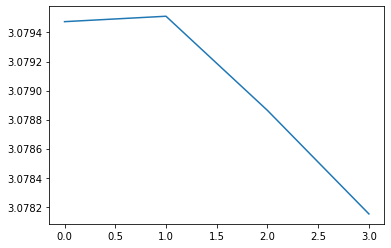

In [41]:
# Количество кадров в последовательности = 20
%matplotlib inline
plt.plot(list(range(0,len(all_losses_20))),all_losses_20)
plt.show()

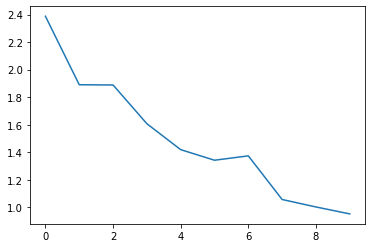

In [27]:
plt.plot(list(range(0,len(all_losses_50))),all_losses_50)
plt.show()

In [29]:
n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 1
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, batch_first=True)
  (dr): Dropout2d(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [31]:
train_dataset, test_dataset = torch.utils.data.random_split(skeletons_20_frames, 
                                                            [int(0.75*len(skeletons_20_frames))+1,
                                                             int(0.25*len(skeletons_20_frames))])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

In [32]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(), lr=learning_rate, momentum=0.9)

all_losses_20_1 = []
start = time.time()
counter = 0
for epoch in range(200):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 10 == 0:
        all_losses_20_1.append(current_loss / 25)
        current_loss = 0

epoch : 0 iter : 0 (0m 0s) 1.8328  / hand waving ✗ (jump up)
epoch : 11 iter : 27 (0m 11s) 1.6297  / jump up ✗ (hand waving)
epoch : 23 iter : 11 (0m 23s) 1.4418  / jump up ✗ (hand waving)
epoch : 34 iter : 38 (0m 38s) 1.2990  / sitting down ✓
epoch : 46 iter : 22 (0m 53s) 1.2549  / sitting down ✓
epoch : 58 iter : 6 (1m 7s) 1.1718  / dancing ✓
epoch : 69 iter : 33 (1m 21s) 1.1436  / dancing ✓
epoch : 81 iter : 17 (1m 39s) 0.7561  / clapping ✓
epoch : 93 iter : 1 (1m 58s) 0.8481  / jump up ✓
epoch : 104 iter : 28 (2m 16s) 0.8962  / jump up ✗ (dancing)
epoch : 116 iter : 12 (2m 35s) 0.8619  / clapping ✓
epoch : 127 iter : 39 (2m 54s) 0.8798  / hand waving ✓
epoch : 139 iter : 23 (3m 11s) 1.0680  / jump up ✓
epoch : 151 iter : 7 (3m 28s) 0.6795  / sitting down ✓
epoch : 162 iter : 34 (3m 47s) 0.6122  / clapping ✗ (jump up)
epoch : 174 iter : 18 (4m 3s) 0.5831  / clapping ✓
epoch : 186 iter : 2 (4m 18s) 0.8113  / dancing ✓
epoch : 197 iter : 29 (4m 35s) 1.0236  / hand waving ✗ (clapping)


In [33]:
n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 5
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=5, batch_first=True)
  (dr): Dropout2d(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [34]:
train_dataset, test_dataset = torch.utils.data.random_split(skeletons_20_frames, 
                                                            [int(0.75*len(skeletons_20_frames))+1,
                                                             int(0.25*len(skeletons_20_frames))])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

In [35]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(), lr=learning_rate, momentum=0.9)

all_losses_20_5 = []
start = time.time()
counter = 0
for epoch in range(200):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 10 == 0:
        all_losses_20_5.append(current_loss / 25)
        current_loss = 0

epoch : 0 iter : 0 (0m 0s) 1.7961  / sitting down ✗ (clapping)
epoch : 11 iter : 27 (0m 44s) 1.7935  / cheer up ✗ (dancing)
epoch : 23 iter : 11 (1m 20s) 1.7923  / clapping ✓
epoch : 34 iter : 38 (1m 57s) 1.8021  / clapping ✗ (cheer up)
epoch : 46 iter : 22 (2m 31s) 1.8020  / clapping ✗ (dancing)
epoch : 58 iter : 6 (3m 10s) 1.7941  / clapping ✓
epoch : 69 iter : 33 (3m 56s) 1.7879  / clapping ✗ (jump up)
epoch : 81 iter : 17 (4m 31s) 1.7969  / clapping ✗ (hand waving)
epoch : 93 iter : 1 (5m 7s) 1.8103  / clapping ✗ (hand waving)
epoch : 104 iter : 28 (5m 44s) 1.7958  / clapping ✗ (jump up)
epoch : 116 iter : 12 (6m 21s) 1.8056  / clapping ✓
epoch : 127 iter : 39 (6m 54s) 1.8003  / clapping ✗ (sitting down)
epoch : 139 iter : 23 (7m 29s) 1.7898  / clapping ✗ (cheer up)
epoch : 151 iter : 7 (8m 4s) 1.7948  / clapping ✓
epoch : 162 iter : 34 (8m 39s) 1.7807  / clapping ✗ (hand waving)
epoch : 174 iter : 18 (9m 12s) 1.7818  / clapping ✗ (sitting down)
epoch : 186 iter : 2 (9m 47s) 1.7989

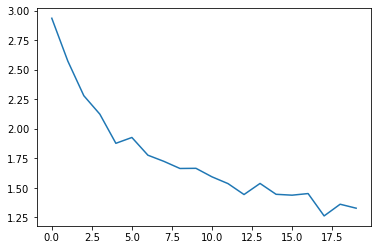

In [36]:
# Количество модулей - 1
%matplotlib inline
plt.plot(list(range(0,len(all_losses_20_1))),all_losses_20_1)
plt.show()

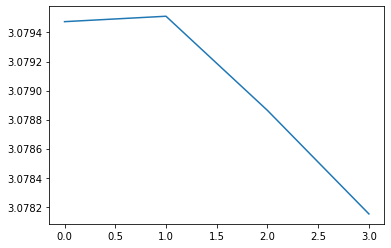

In [42]:
# 2
%matplotlib inline
plt.plot(list(range(0,len(all_losses_20))),all_losses_20)
plt.show()

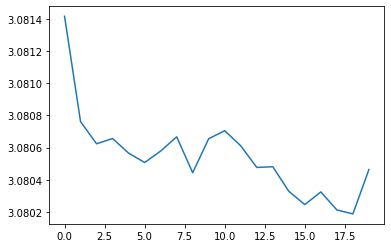

In [38]:
# 5
%matplotlib inline
plt.plot(list(range(0,len(all_losses_20_5))),all_losses_20_5)
plt.show()